[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation.

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [26]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content=f"So you said you were investigating a dlp case?", name="Model")]
messages.append(SystemMessage(content=f'The AI assistant can summarize incidents, check indicators of compromise (IOCs), and suggest remediation steps'))
messages.append(HumanMessage(content=f"Yes, that's right.",name="Mandil"))
messages.append(AIMessage(content=f"Great, what help do you need?", name="Model"))
messages.append(HumanMessage(content=f"I want to learn whether these indicators of compromise imply a threat or not", name="Mandil"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were investigating a dlp case?
================================ System Message ================================

The AI assistant can summarize incidents, check indicators of compromise (IOCs), and suggest remediation steps
================================ Human Message =================================
Name: Mandil

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what help do you need?
================================ Human Message =================================
Name: Mandil

I want to learn whether these indicators of compromise imply a threat or not


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI.

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [27]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [28]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [29]:
result

AIMessage(content="Of course, I can help with that. Please provide the indicators of compromise (IOCs) you have, such as suspicious IP addresses, domain names, file hashes, or any other relevant information you have collected. I'll help you assess whether they indicate a threat and suggest potential next steps.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 90, 'total_tokens': 148, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a7d06e42a7', 'finish_reason': 'stop', 'logprobs': None}, id='run-ebbff09a-1269-43cb-b102-d32927d212c8-0', usage_metadata={'input_tokens': 90, 'output_tokens': 58, 'total_tokens': 148, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [30]:
result.response_metadata

{'token_usage': {'completion_tokens': 58,
  'prompt_tokens': 90,
  'total_tokens': 148,
  'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_a7d06e42a7',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple.

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!

The `multiply` function is our tool.

In [33]:
def check_ip(ip_address: str) -> str:
    """Check if an IP address is malicious.

    Args:
        ip_address: The IP address to check.

    Returns:
        A string indicating whether the IP is 'malicious' or 'clean'.
    """
    malicious_ips = ["203.0.113.42", "198.51.100.17"]
    if ip_address in malicious_ips:
        return "malicious"
    else:
        return "clean"


llm_with_tools = llm.bind_tools([check_ip])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned.

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [34]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"We've detected a large data transfer to IP address 203.0.113.42", name="Mandil")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lsnPEktFoHcJNYLD2ziQByFf', 'function': {'arguments': '{"ip_address":"203.0.113.42"}', 'name': 'check_ip'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 73, 'total_tokens': 94, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a7d06e42a7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7f49fcac-e6ad-40a7-b438-bc4ef810353b-0', tool_calls=[{'name': 'check_ip', 'args': {'ip_address': '203.0.113.42'}, 'id': 'call_lsnPEktFoHcJNYLD2ziQByFf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 73, 'output_tokens': 21, 'total_tokens': 94, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [35]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_lsnPEktFoHcJNYLD2ziQByFf',
  'function': {'arguments': '{"ip_address":"203.0.113.42"}',
   'name': 'check_ip'},
  'type': 'function'}]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [36]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.

As our graph runs, we want to **append** messages to to our `messages` state key.

We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.

But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [37]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)!

`MessagesState` is defined:

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [38]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [39]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on investigating a dlp case", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='c5afd8bd-408f-436a-ba9e-3729da35a10d'),
 HumanMessage(content="I'm looking for information on investigating a dlp case", additional_kwargs={}, response_metadata={}, name='Lance', id='38cf2ff4-be82-4fa9-93a3-78e6ad62b118'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='cb515b74-da15-4a41-b173-374af9bca794')]

## Our graph

Now, lets use `MessagesState` with a graph.

In [65]:
def tool_calling_llm(state: MessagesState):
    # Get the current messages from the state
    messages = state["messages"]

    # Invoke the model
    ai_message = llm_with_tools.invoke(messages)

    # Initialize a list to hold new messages
    new_messages = [ai_message]

    # Check for tool calls
    if 'tool_calls' in ai_message.additional_kwargs:
        for call in ai_message.additional_kwargs['tool_calls']:
            function_name = call['function']['name']
            arguments = json.loads(call['function']['arguments'])
            # Execute the tool function
            if function_name == 'check_ip':
                result = check_ip(**arguments)
            else:
                result = "Unknown function"
            # Create a ToolMessage with the result
            tool_message = ToolMessage(
                content=result,
                name=function_name,
                tool_call_id=call['id']  # Corrected parameter name
            )
            # Append the ToolMessage
            new_messages.append(tool_message)

        # Invoke the model again with the updated messages
        updated_messages = messages + new_messages
        final_response = llm_with_tools.invoke(updated_messages)
        new_messages.append(final_response)
    else:
        # No tool calls; proceed normally
        pass  # You can add logic here if needed

    # Return the new messages
    return {"messages": new_messages}

    '''
    Explanation:

    Invoke the Model: We invoke the model with the current conversation messages.

    Check for Tool Calls: We examine the model's response to see if it includes any tool calls.

    Execute Tool Functions: For each tool call, we execute the corresponding tool function with the provided arguments.

    Create a ToolMessage: We create a ToolMessage containing the result of the tool function execution.

    Update Messages: We append the AIMessage and ToolMessage to the new messages list.

    Invoke the Model Again: We invoke the model again with the updated messages to get the final response.'''



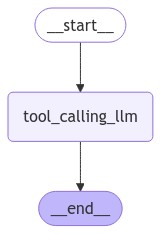

In [57]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [58]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [59]:
messages = graph.invoke({"messages": HumanMessage(content="We've detected a large data transfer to IP address 203.0.113.42")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

We've detected a large data transfer to IP address 203.0.113.42
================================== Ai Message ==================================
Tool Calls:
  check_ip (call_7TlknxZGhmWnZYF0L0zuWZf7)
 Call ID: call_7TlknxZGhmWnZYF0L0zuWZf7
  Args:
    ip_address: 203.0.113.42


In [60]:
initial_state = {"messages": messages}


In [63]:
# Invoke the graph
result_state = graph.invoke(initial_state)

In [64]:
for m in result_state['messages']:
    m.pretty_print()


================================== Ai Message ==================================
Name: Model

So you said you were investigating a DLP case?
================================ System Message ================================

The AI assistant can summarize incidents, check indicators of compromise (IOCs), and suggest remediation steps
================================ Human Message =================================
Name: Mandil

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what help do you need?
================================ Human Message =================================
Name: Mandil

We've detected a large data transfer to IP address 203.0.113.42.
================================== Ai Message ==================================
Tool Calls:
  check_ip (call_gHMAB42JEe9xgTwOEULziZGx)
 Call ID: call_gHMAB42JEe9xgTwOEULziZGx
  Args:
    ip_address: 203.0.113.42
================================= Tool Message ========

In [62]:
# # Import necessary modules
# from pprint import pprint
# from typing import Annotated
# from typing_extensions import TypedDict
# from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage, AnyMessage
# from langchain_openai import ChatOpenAI
# from langgraph.graph import StateGraph, START, END
# from langgraph.graph.message import add_messages
# import json
# import os, getpass

# # Ensure the OPENAI_API_KEY is set
# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

# # Define the initial messages
# messages = [
#     AIMessage(content="So you said you were investigating a DLP case?", name="Model"),
#     SystemMessage(content="The AI assistant can summarize incidents, check indicators of compromise (IOCs), and suggest remediation steps"),
#     HumanMessage(content="Yes, that's right.", name="Mandil"),
#     AIMessage(content="Great, what help do you need?", name="Model"),
#     HumanMessage(content="We've detected a large data transfer to IP address 203.0.113.42.", name="Mandil")
# ]

# # Optional: Print the initial messages
# for m in messages:
#     m.pretty_print()

# # Define the tool function
# def check_ip(ip_address: str) -> str:
#     """Check if an IP address is malicious.

#     Args:
#         ip_address: The IP address to check.

#     Returns:
#         A string indicating whether the IP is 'malicious' or 'clean'.
#     """
#     malicious_ips = ["203.0.113.42", "198.51.100.17"]
#     if ip_address in malicious_ips:
#         return "malicious"
#     else:
#         return "clean"

# # Set up the chat model and bind the tool
# llm = ChatOpenAI(model="gpt-4")
# llm_with_tools = llm.bind_tools([check_ip])

# # Define the MessagesState with the add_messages reducer
# class MessagesState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

# # Define the graph node that handles tool calls
# def tool_calling_llm(state: MessagesState):
#     # Get the current messages from the state
#     messages = state["messages"]

#     # Invoke the model
#     ai_message = llm_with_tools.invoke(messages)

#     # Initialize a list to hold new messages
#     new_messages = [ai_message]

#     # Check for tool calls
#     if 'tool_calls' in ai_message.additional_kwargs:
#         for call in ai_message.additional_kwargs['tool_calls']:
#             function_name = call['function']['name']
#             arguments = json.loads(call['function']['arguments'])
#             # Execute the tool function
#             if function_name == 'check_ip':
#                 result = check_ip(**arguments)
#             else:
#                 result = "Unknown function"
#             # Create a ToolMessage with the result
#             tool_message = ToolMessage(
#                 content=result,
#                 name=function_name,
#                 tool_call_id=call['id']  # Corrected parameter name
#             )
#             # Append the ToolMessage
#             new_messages.append(tool_message)

#         # Invoke the model again with the updated messages
#         updated_messages = messages + new_messages
#         final_response = llm_with_tools.invoke(updated_messages)
#         new_messages.append(final_response)
#     else:
#         # No tool calls; proceed normally
#         pass  # You can add logic here if needed

#     # Return the new messages
#     return {"messages": new_messages}

# # Build the graph
# builder = StateGraph(MessagesState)
# builder.add_node("tool_calling_llm", tool_calling_llm)
# builder.add_edge(START, "tool_calling_llm")
# builder.add_edge("tool_calling_llm", END)
# graph = builder.compile()

# # Prepare the initial state
# initial_state = {"messages": messages}

# # Invoke the graph
# result_state = graph.invoke(initial_state)

# # Print the conversation
# for m in result_state['messages']:
#     m.pretty_print()


================================== Ai Message ==================================
Name: Model

So you said you were investigating a DLP case?
================================ System Message ================================

The AI assistant can summarize incidents, check indicators of compromise (IOCs), and suggest remediation steps
================================ Human Message =================================
Name: Mandil

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what help do you need?
================================ Human Message =================================
Name: Mandil

We've detected a large data transfer to IP address 203.0.113.42.
================================== Ai Message ==================================
Name: Model

So you said you were investigating a DLP case?
================================ System Message ================================

The AI assistant can summarize incidents, che